# Data identification and acquisition

## Useful utilities
Since problems will happen, we need to be able to handle them in a nice and clean way.

### Delete duplicates
This script deletes all the duplicate lines from `gigs.txt` and can be easily modified for `categories.txt`.
Notice that unlike post-processing, this script **can make the time require to scrap** faster.

In [ ]:
with open('gigs.txt', 'r') as f:
    lines = f.readlines()

lines_set = set(lines)
lines_set = sorted(lines_set)

with open('gigs.txt', 'w') as f:
    f.writelines(lines_set)

print('Deleted ' + str(len(lines) - len(lines_set)) + ' duplicate lines.')

### Reversing the order of the lines
If two users wants to scrap the same data, they can do it in parallel by reversing the order of the lines in `gigs.txt` and `categories.txt`.
this can be easily done by appending `[::-1]` to the end of of every list that is being enumerated in the `#Crawling` section.

## Importing necessary libraries

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from selenium_stealth import stealth
from bs4 import BeautifulSoup
from pprint import pprint
import csv
import threading
import os
import sys
import traceback

## Initializations

### Initialize stealthy Chrome driver

In [ ]:
options = Options()
options.add_argument("start-maximized")
options.add_experimental_option("excludeSwitches", ["enable-automation"])
options.add_experimental_option('useAutomationExtension', False)

chrome_driver_path = r"C:\Users\Deftera\Downloads\chromedriver_win32\chromedriver.exe"
s = Service(chrome_driver_path)

driver = webdriver.Chrome(service=s, options=options, service_args=["--verbose"])

stealth(driver,
      languages=["en-US", "en"],
      vendor="Google Inc.",
      platform="Win32",
      webgl_vendor="Intel Inc.",
      renderer="Intel Iris OpenGL Engine",
fix_hairline=True,)

### Initialize the timeout_callback function
Since the data is being scraped using selenium_stealth, which is very unstable, the driver can get stuck at any point of time. To avoid this, we use a timeout_callback function which will be called if the driver gets stuck. This function will then `taskkill` the driver and the current process. (**Note:** This function is neccessary to continue the scraping process even if the driver gets stuck, a `.bat` file will be responsible for restarting the process)

In [ ]:
def timeout_callback(category_url):
    os.system("taskkill /F /IM chrome.exe /T") 
    sys.exit()

To make sure the program is running correctly, extract the jupyter notebook as a `.py` file, and run it with the following batch script.

`gigs.txt` is a file containing the links of all the gigs to be scraped. The links are separated by a newline character.
A similar file layout and batch script should be used for the category links as well.

In [ ]:
@echo off

set "gigs_file=gigs.txt"
set "python_script=get_gigs.py"
set "timeout_seconds=5"

:loop
set /p first_line=<"%gigs_file%"
timeout /t %timeout_seconds% /nobreak >nul
python "%python_script%"

set /p new_first_line=<"%gigs_file%"
if "%new_first_line%"=="%first_line%" (
    call :removeDuplicateLine
)

goto loop

:removeDuplicateLine
ren "%gigs_file%" "gigs_temp.txt"
for /f "skip=1 delims=" %%a in (gigs_temp.txt) do echo %%a>>"%gigs_file%"
del "gigs_temp.txt"
exit /b

### Initialize the crawling functions

In [ ]:
def crawl_category(category_url, gigs_limit=15):
    """
    Crawls a given category url and returns a list of the URLs of the gigs on the page
    :param category_url: the url of the category to crawl
    :param gigs_limit: the maximum number of gigs to return
    :return: a list of gigs URLs with length of up to gigs_limit
    """
    
    # Set a timer to kill the process if it takes too long
    timer = threading.Timer(18 , timeout_callback, [category_url])
    timer.start()
    try:
        print("trying to reach " + category_url)
        driver.get(category_url)
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        gigs = soup.select("div.gig-card-layout > div.gig-wrapper > div.basic-gig-card > a")
        if len(gigs) == 0:
            # If no gigs were found, stop the timer and return an empty list
            timer.cancel()
            return []
        gigs_links = [gig.get("href") for gig in gigs]
        if len(gigs_links) == 0:
            # if no gig *links* were found, stop the timer and return an empty list
            timer.cancel()
            return []
        full_gigs_links = [f"https://www.fiverr.com{link}" for link in gigs_links] # add the domain to the links
        full_gigs_links = list(set(full_gigs_links)) # remove duplicates
        timer.cancel()
    except Exception as e:
        sys.exit() # kill the process if an exception is raised
    return full_gigs_links[:gigs_limit]

In [ ]:
def crawl_gig(gig_url):
    """
    Crawls a given gig url and returns a dictionary of the gig's data
    :param gig_url: the url of the gig to crawl
    :return: a dictionary of the gig's data 
    (title, rating score, orders in queue, rating counts, seller level, category, delivery times, prices,
    revisions, tags, language, country, member since and features)
    """

    # Set a timer to kill the process if it takes too long
    timer = threading.Timer(18, timeout_callback, [gig_url])
    timer.start()
    try:
        print("trying to reach " + gig_url)
        driver.get(gig_url)
        soup = BeautifulSoup(driver.page_source, "html.parser")

        # load the gig's overview
        gig_overview = soup.select_one(
            "div.main-content > div#__ZONE__main > div.gig_page_perseus > div.gig-page-wrapper > div.gig-page > div.main > div.gig-overview"
        )
        gig_title = gig_overview.select_one("h1").text
        seller_overview = gig_overview.select_one("div.seller-overview")
        try:
            rating_score = seller_overview.select_one("b.rating-score").text
        except:
            # if no rating score was found, set it to 0
            rating_score = 0
        try:
            seller_level = seller_overview.select_one(
                "div.Waqjn3u > div.user-profile-image"
            ).text
        except:
            # Sometimes the seller level is in another place, so if the first selector didn't work, try another one
            seller_level = soup.select_one(
                "span.level > div.jEW3B9z > span.HsyURQF"
            ).text
        try:
            rating_counts = (
                seller_overview.select_one("span.ratings-count")
                .text.replace("(", "")
                .replace(")", "")
            )
        except:
            # if no rating counts were found, set it to 0
            # also, it means that the seller is new, so set the seller level to 0
            rating_counts = 0
            seller_level = 0
        try:
            orders_in_queue = seller_overview.select_one("div.sfNimsX").text.split(" ")[
                0
            ]
        except:
            # if no orders in queue were found, set it to 0
            orders_in_queue = 0
        try:
            # Get the gig's package details
            packages_table = soup.select_one("div.gig-page-packages-table")
            delivery_times = packages_table.select_one("tr.delivery-time").select("td")[
                1:
            ]
            for index, delivery_time in enumerate(delivery_times):
                first_span = delivery_time.select_one("span:not([class])")
                if first_span:
                    delivery_times[index] = first_span.text
                else:
                    delivery_times[index] = delivery_time.text

            features = packages_table.select("tr.description > td")
            features = features[1:]
            for i in range(len(features)):
                features[i] = features[i].text

            prices = packages_table.select_one("tr.select-package").select(
                "td > div.price-wrapper > p"
            )
            prices = [price.text for price in prices]
            try:
                revisions = packages_table.select("tr:not([class])")[-1].select("td")[
                    1:
                ]
                revisions = [revision.text for revision in revisions]
            except:
                revisions = []

            tags = soup.select("div.gig-tags-container > ul > li > a")
            extracted_tags = []
            for tag in tags:
                extracted_tags.append(str(tag).split(">")[1][:-4])

            country = soup.select(
                "div.profile-card > div.seller-card > div.stats-desc > ul.user-stats > li > strong"
            )
            member_since = str(country[1]).split(">")[1][:-8]
            country = str(country[0]).split(">")[1][:-8]
            language = soup.select_one("span.HsyURQF > strong").text

            category = soup.select("span.category-breadcrumbs")[-1].select_one("a").text
        except:
            # sometimes gig's package details are not available, so set them to None
            # because their data won't help us in our analysis
            timer.cancel()
            return None
        timer.cancel()
    except Exception as e:
        # if an exception is raised, kill the process
        sys.exit()
    return {
        "gig_title": gig_title,
        "rating_score": rating_score,
        "orders_in_queue": orders_in_queue,
        "rating_counts": rating_counts,
        "seller_level": seller_level,
        "category": category,
        "delivery_times": delivery_times,
        "prices": prices,
        "revisions": revisions,
        "tags": extracted_tags,
        "language": language,
        "country": country,
        "member_since": member_since,
        "features": features,
    }


## Crawling the data

### Crawling the category links
Because we want to take data from all the categories, we first need to get the links of all the categories. This is done by the following function that crawls the category links and stores them in a file called `categories.txt`.

In [ ]:
try:
    with open('categories.txt', 'r') as f:
        full_categories_links = f.read().splitlines()
except:
    CATEGORIES_URL = "https://www.fiverr.com/categories"
    driver.get(CATEGORIES_URL)
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    categories = soup.select("section.mp-categories-columns.cf > ul > li > a")
    categories_links = [category.get("href") for category in categories]
    full_categories_links = [f"https://www.fiverr.com{link}" for link in categories_links]

    with open('categories.txt', 'w') as f:
        for item in full_categories_links:
            f.write("%s\n" % item)

try:
    with open('gigs.txt', 'r') as f:
        gigs_links = f.read().splitlines()
except:
    gigs_links = []

### Crawling the gig links from the category links
Notice that the links are constantly being appended to the `gigs.txt` file. This is because the driver can get stuck at any point of time, and we don't want to lose the links that have already been crawled. So, with the help of the `.bat` file, we can restart the process from the last link that was crawled.

In [ ]:
for category_url in full_categories_links: # If reading in reverse order, you might wanna use full_categories_links[::-1] instead
    if category_url in gigs_links:
        continue
    pprint("created timer")
    gigs = crawl_category(category_url)
    
    gigs_links += gigs
    with open('gigs.txt', 'a') as f:
        for item in gigs:
            f.write("%s\n" % item)
    with open('categories.txt', 'r') as f:
        lines = f.readlines()
    with open('categories.txt', 'w') as f:
        for line in lines:
            if line.strip("\n") != category_url:
                f.write(line)

### Crawling the gig data from the gig links
Notice that the same script is being used to crawl the gig data as well. This is because the driver can get stuck at any point of time, and we don't want to lose the data that has already been crawled. So, with the help of the `.bat` file, we can restart the process from the last link that was crawled.

In [ ]:
try:
    with open('gigs_data.csv', 'r') as f:
        pass
except:
    with open('gigs_data.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["gig_title", "rating_score", "orders_in_queue", "rating_counts", "seller_level", "category", "delivery_times", "prices", "revisions", "tags", "language", "country", "member_since", "features"])

for gig_link in gigs_links:
    gig_data = crawl_gig(gig_link)
    if gig_data == None:
        with open('gigs.txt', 'r') as f:
            lines = f.readlines()
        with open('gigs.txt', 'w') as f:
            for line in lines:
                if line.strip("\n") != gig_link:
                    f.write(line)
        continue

    # since we are dealing with hebrew, we need to encode the data to utf-8
    with open('gigs_data.csv', 'a', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow([gig_data["gig_title"], gig_data["rating_score"], gig_data["orders_in_queue"], gig_data["rating_counts"], gig_data["seller_level"], gig_data["category"], gig_data["delivery_times"], gig_data["prices"], gig_data["revisions"], gig_data["tags"], gig_data["language"], gig_data["country"], gig_data["member_since"], gig_data["features"]] )
    with open('gigs.txt', 'r') as f:
        lines = f.readlines()
    with open('gigs.txt', 'w') as f:
        for line in lines:
            if line.strip("\n") != gig_link:
                f.write(line)

driver.quit()
# This function can make sure no process is left running in the background
timeout_callback(1)

# Fix Data

importing all the needed libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as p
import math
import re

%matplotlib inline


Reading the file from the csv file

In [ ]:
gigs = pd.read_csv('gigs_data.csv', encoding='latin-1')
print(gigs.head())
len(gigs)

Removing the duplicates from the data frame. Duplicates might cause problems in the future, and we don't need them.

In [ ]:
gigs.drop_duplicates(inplace=True)

The price of each gig was in NIS, when converting to utf-8, it added a weird symbol that we had to remove.
In addition to that, we saved the data in a list, and the csv file converted it to a string. We had to undo it, and transform it back to a list of floats.

In [ ]:
# remove the weird 'âª' character from the prices column 
gigs['prices'] = gigs['prices'].str.replace('âª', '')

def convert_prices(prices_str):
    '''Converts a string of prices to a list of floats'''
    prices_str = prices_str.strip('[]').split(', ')
    prices_float = []
    for price in prices_str:
        price = price.replace(',', '').replace("'", "")
        prices_float.append(float(price))
    return prices_float

gigs['prices'] = gigs['prices'].apply(convert_prices)

gigs.head()


While crawling, the browser of one of us was in Hebrew, which cause some letter to be in utf-8 Hebrew version. We had to make a dictionery for each utf-8 Hebrew sign, and then convert it to a normal date format.

In [ ]:
# Convert member_since column (3 first letter of month-last 2 digit of year, Ex: Sep-19) to epoch time
def convert_member_since(member_since_str):
    '''Converts a string of member_since to epoch time'''
    member_since_str = member_since_str.split('-')
    if (len(member_since_str) == 1):
        return None
    month = member_since_str[0]
    year = member_since_str[1]
    month_dict = {'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05',
                 'Jun': '06', 'Jul': '07', 'Aug': '08', 'Sep': '09', 'Oct': '10',
                 'Nov': '11', 'Dec': '12', 'éåð': '06', 'àå÷': '10', 'éðå': '01', 'àôø': '04', 'îøõ': '03', 'ðåá': '11', 'ñôè':'09', 'îàé':'05', "éåì":'07', "ãöî":'12', "ôáø": '02', "àåâ": '08'}
    month = month_dict[month]
    member_since_str = '20' + year + '-' + month + '-01'
    return pd.to_datetime(member_since_str)

gigs['member_since'] = gigs['member_since'].apply(convert_member_since)

gigs.head()

The recisions were also stored in a list. But the csv format made it a string of string inside a list. 
We had to convert it to a normal list of integers, and replace the word "Unlimited" with np.inf (infinite).

In [ ]:
def convert_revisions(revisions_str):
    '''Converts a string of revisions to a list of floats'''
    revisions_str = revisions_str.strip('[]').split(', ')
    revisions_float = []
    for revision in revisions_str:
        revision = revision.replace(',', '').replace("'", "")
        if revision == 'Unlimited':
            revision = np.inf
            revisions_float.append(float(revision))
        else:
            if revision == '':
                revision = 0
            revisions_float.append(int(revision))
    return revisions_float

gigs['revisions'] = gigs['revisions'].apply(convert_revisions)

gigs.head()

The delivery times were also converted to a string beacause of the csv file format.
In addition to that we had to remove the word "day" or "days" from the end of each number.

In [ ]:
gigs['delivery_times'] = gigs['delivery_times'].str.replace('day', '')
gigs['delivery_times'] = gigs['delivery_times'].str.replace("s", "")
gigs['delivery_times'] = gigs['delivery_times'].str.strip()

def convert_delivery_time(delivery_time_str):
    '''Converts a string of prices to a list of floats'''
    delivery_time_str = delivery_time_str.strip('[]').split(', ')
    delivery_times_int = []
    for price in delivery_time_str:
        price = price.replace(',', '').replace("'", "")
        delivery_times_int.append(int(price))
    return delivery_times_int

gigs['delivery_times'] = gigs['delivery_times'].apply(convert_delivery_time)

gigs.head()


We made a dictionery that converts each level to a number.

In [ ]:
def convert_level(level_str):
    level_conversion = {'Top Rated Seller': 3, 'Level 2 Seller': 2, 'Level 1 Seller': 1, 'New Seller': 0, '0': 0}
    return level_conversion[level_str]

gigs['seller_level'] = gigs['seller_level'].apply(convert_level)

gigs.head()

In [ ]:
# save new dataframe to csv called gigs_data_cleaned.df as pickle
gigs.to_pickle('gigs_data_cleaned.df')

In [110]:
# load gigs_data_cleaned.df (pickle)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from wordcloud import WordCloud
import seaborn as sns

# load data
with open('gigs_data_cleaned.df', 'rb') as f:
    gigs_data_cleaned = pickle.load(f)

gigs_data_cleaned.head()

,gig_title,rating_score,orders_in_queue,rating_counts,seller_level,category,delivery_times,prices,revisions,tags,language,country,member_since,features
0,I will design product advertisement poster and...,4.9,4,411,2,Poster Design,"[4, 4, 5]","[117.33, 156.44, 332.43]","[3, 6, inf]","['advertising poste', 'product poste', 'facebo...","English, Hindi",India,2019-06-01,"['1 Poster design + JPG, PNG, Print-Ready PDF ..."
1,I will make an animated lottie json for web or...,5.0,0,576,3,Lottie & Web Animation,"[2, 2, 3]","[136.88, 273.77, 625.76]","[1, 2, 2]","['lotti', 'gi', 'websit', 'sv']","English, Ukrainian",Ukraine,2020-03-01,"['Basic animation of one element - icon, butto..."
2,I will create high converting google ads ppc a...,4.9,3,27,2,Search Engine Marketing Management,"[4, 7, 10]","[567.09, 1017.0, 1350.0]","[1, 1, 1]","['google adword', 'google ad']","English, Czech, German",Germany,2021-04-01,['Setup 1 Campaign + Keywords Research + High...
3,I will do editing and fact checking ai generat...,5.0,0,1,1,Fact Checking,"[1, 1, 1]","[19.55, 39.11, 58.66]","[0, 0, 0]","['a', 'copywritin', 'article write']","English, Urdu",Pakistan,2021-11-01,"['i will write using chatgpt ', 'i will write ..."
4,I will create a pixel collectibles for nft col...,5.0,2,241,2,NFT Art,"[2, 3, 5]","[39.11, 136.88, 254.21]","[1, 1, 1]","['nft ar', 'nft desig', 'nft pixel ar', 'nf']","English, Indonesian, Javanese",Indonesia,2019-09-01,['[CONTACT ME FIRST BEFORE ORDER]\r\nYou can g...


median score:  195.0
mean score:  594.3408475648324
average score:  566.8071419954157


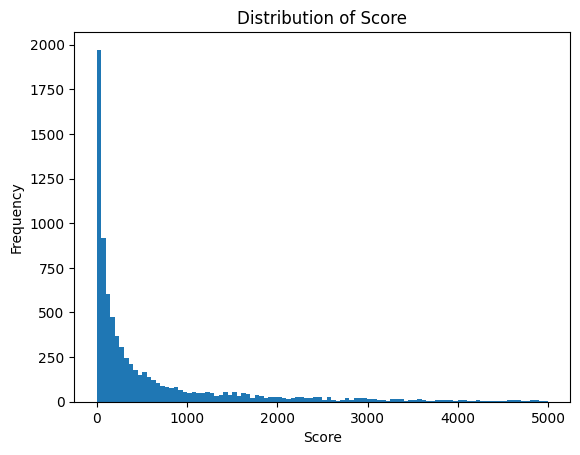

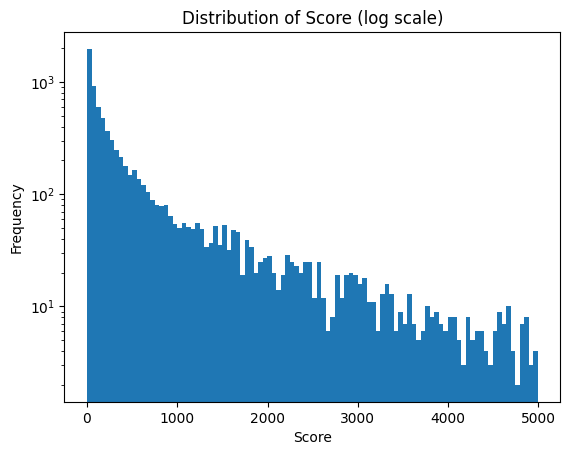

In [111]:
gigs_data_cleaned['rating_counts'] = pd.to_numeric(gigs_data_cleaned['rating_counts'], errors='coerce')
gigs_data_cleaned['rating_score'] = pd.to_numeric(gigs_data_cleaned['rating_score'], errors='coerce')
gigs_data_cleaned['score'] = gigs_data_cleaned['rating_counts'] * gigs_data_cleaned['rating_score']

# find the median, mean, average of 'score' column
median_score = gigs_data_cleaned['score'].median()
mean_score = gigs_data_cleaned['score'].mean()
average_score = gigs_data_cleaned['score'].sum() / len(gigs_data_cleaned['score'])

print('median score: ', median_score)
print('mean score: ', mean_score)
print('average score: ', average_score)

# plot the distribution of 'score' column
plt.hist(gigs_data_cleaned['score'], bins=100)
plt.title('Distribution of Score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

# plot it again with log scale
plt.hist(gigs_data_cleaned['score'], bins=100)
plt.title('Distribution of Score (log scale)')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

In [112]:
def convert_text_to_frequency_dict(text):
    words = text.split()
    frequency_dict = {}
    for word in words:
        if word in frequency_dict:
            frequency_dict[word] += 1
        else:
            frequency_dict[word] = 1
    return frequency_dict

def frequencies_to_wordcloud(frequencies, max_words=100, title=None):
    wordcloud = WordCloud(width=1600, height=800, max_font_size=200, max_words=max_words).generate_from_frequencies(frequencies)
    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()


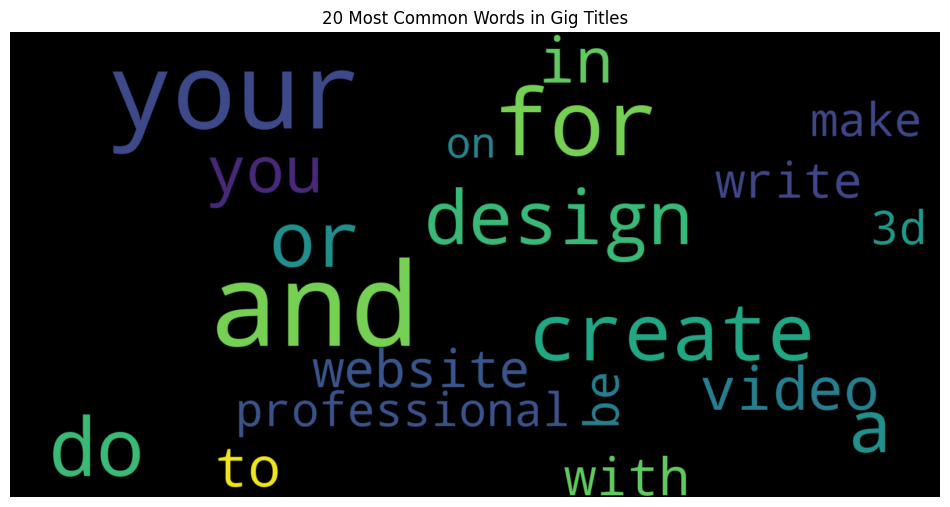

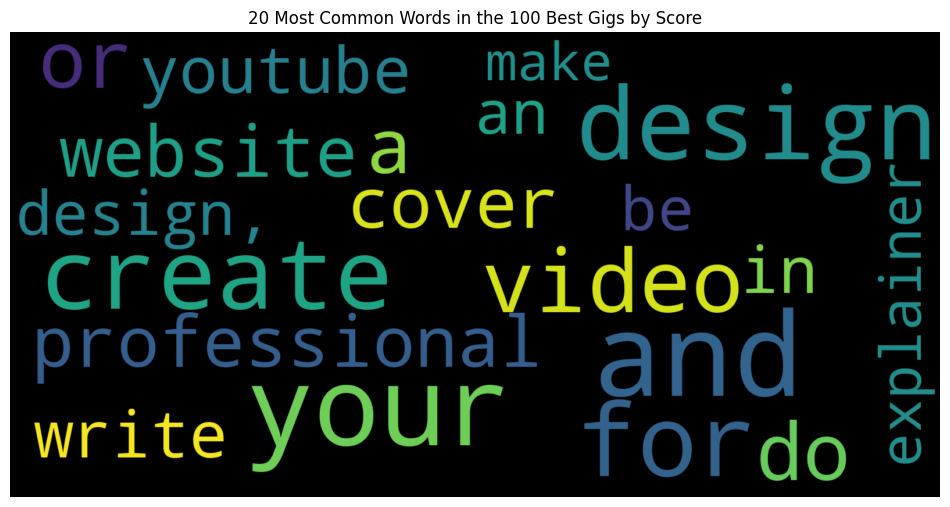

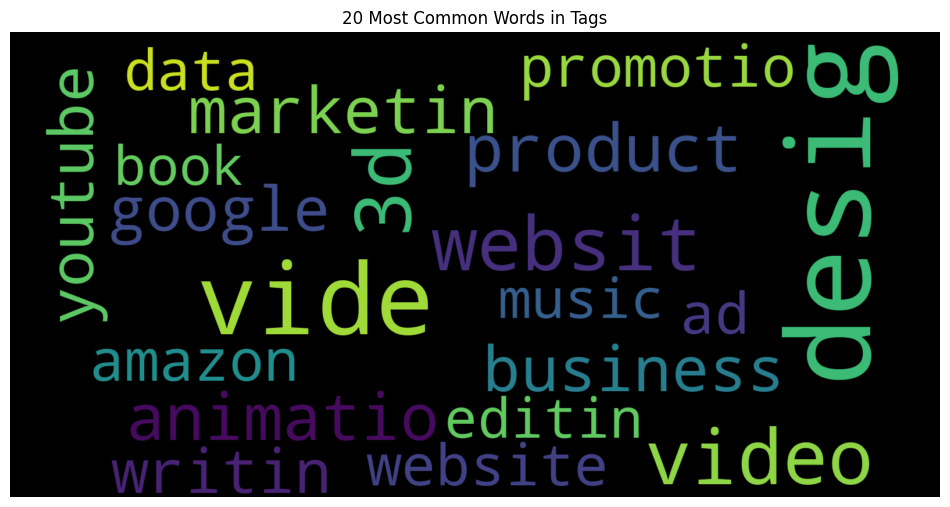

In [120]:
frequencies_all = convert_text_to_frequency_dict(gigs_data_cleaned['gig_title'].str.cat(sep=' '))

frequencies_all.pop('I', None)
frequencies_all.pop('will', None)

frequencies_to_wordcloud(frequencies_all, max_words=20, title="20 Most Common Words in Gig Titles")

# top 20 words in the 100 best gigs by score
frequencies = convert_text_to_frequency_dict(gigs_data_cleaned.sort_values(by='score', ascending=False).head(100)['gig_title'].str.cat(sep=' '))
frequencies.pop('I', None)
frequencies.pop('will', None)
frequencies_to_wordcloud(frequencies, max_words=20, title="20 Most Common Words in the 100 Best Gigs by Score")

# wordcloud of tags column (string that look like "['tag1', 'tag2', 'tag3']")
tags = gigs_data_cleaned['tags'].str.cat(sep=' ')
tags = tags.replace('[', '')
tags = tags.replace(']', '')
tags = tags.replace("'", '')
tags = tags.replace(",", '')
tags = tags.replace("  ", ' ')
frequencies = convert_text_to_frequency_dict(tags)
frequencies_to_wordcloud(frequencies, max_words=20, title="20 Most Common Words in Tags")


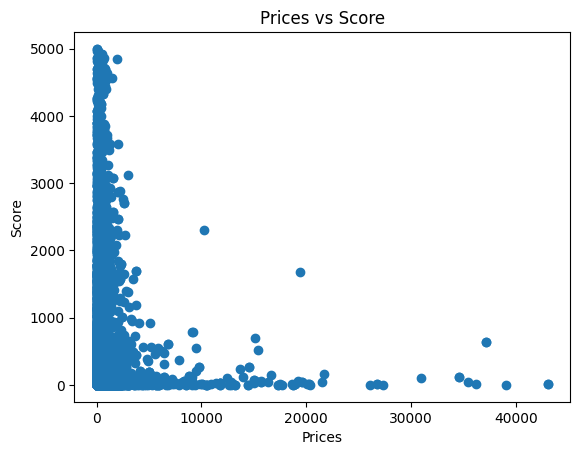

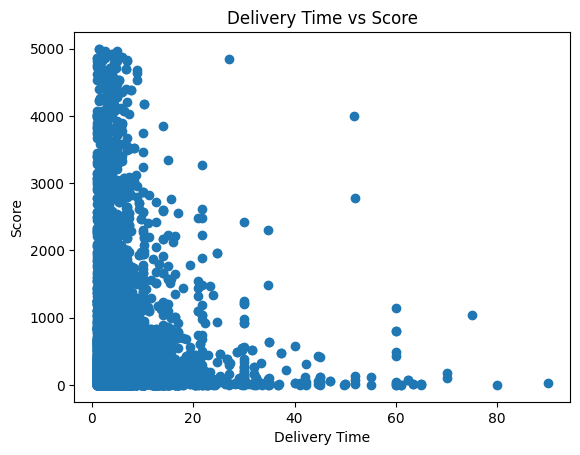

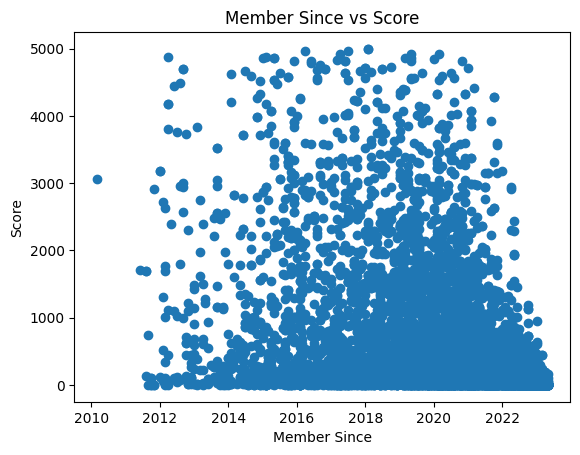

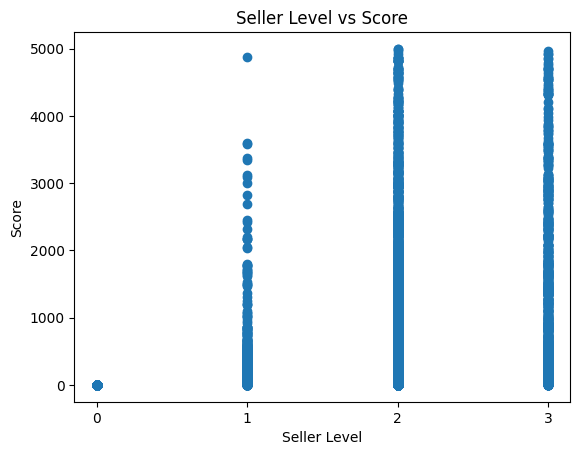

In [117]:
# create average price from the prices column list
gigs_data_cleaned['average_price'] = gigs_data_cleaned['prices'].apply(lambda x: np.mean(x))
# plot the prices vs the score
plt.scatter(gigs_data_cleaned['average_price'], gigs_data_cleaned['score'])
plt.title('Prices vs Score')
plt.xlabel('Prices')
plt.ylabel('Score')
plt.show()

# create average delivery time from the delivery_time column list
gigs_data_cleaned['average_delivery_time'] = gigs_data_cleaned['delivery_times'].apply(lambda x: np.mean(x))

# plot the delivery time vs the score
plt.scatter(gigs_data_cleaned['average_delivery_time'], gigs_data_cleaned['score'])
plt.title('Delivery Time vs Score')
plt.xlabel('Delivery Time')
plt.ylabel('Score')
plt.show()

# plot the member since vs the score
plt.scatter(gigs_data_cleaned['member_since'], gigs_data_cleaned['score'])
plt.title('Member Since vs Score')
plt.xlabel('Member Since')
plt.ylabel('Score')
plt.show()

# plot the seller_level vs the score, 
# MAKE SURE only the values 0,1,2,3 are plotted in the x-axis
plt.scatter(gigs_data_cleaned['seller_level'], gigs_data_cleaned['score'])
plt.title('Seller Level vs Score')
plt.xlabel('Seller Level')
plt.xticks([0,1,2,3])
plt.ylabel('Score')
plt.show()



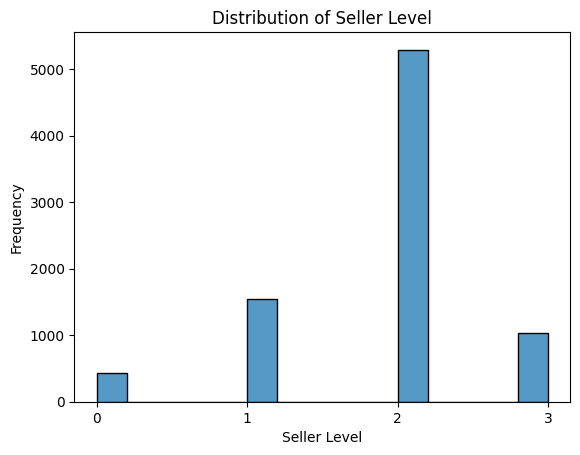

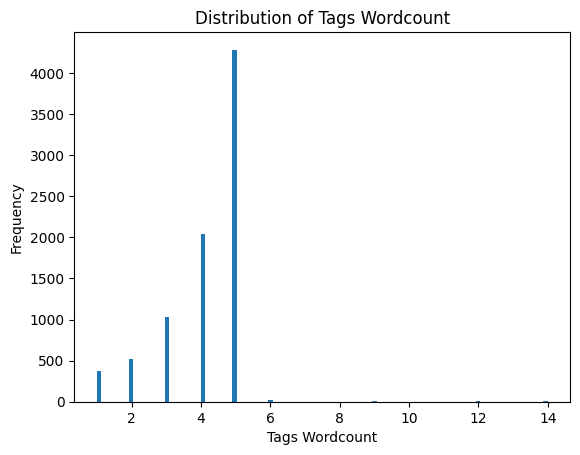

In [121]:
# plot the distribution of the level of the seller 
sns.histplot(gigs_data_cleaned['seller_level'])
plt.title('Distribution of Seller Level')
plt.xlabel('Seller Level')
plt.xticks([0,1,2,3])
plt.ylabel('Frequency')
plt.show()

# wordcount of tags column (string that look like "['tag1', 'tag2', 'tag3']")
gigs_data_cleaned['tags_wordcount'] = gigs_data_cleaned['tags'].str.count(',') + 1

# plot the distribution of 'tags_wordcount' column
plt.hist(gigs_data_cleaned['tags_wordcount'], bins=100)
plt.title('Distribution of Tags Wordcount')
plt.xlabel('Tags Wordcount')
plt.ylabel('Frequency')
plt.show()

/tmp/ipykernel_28605/1074745358.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


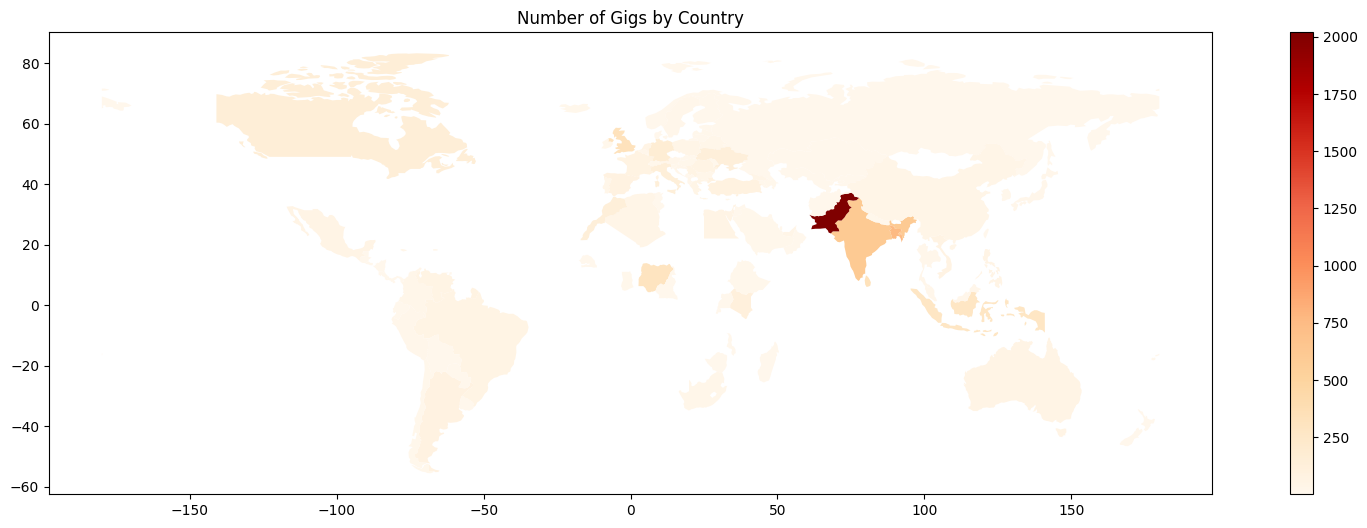

/tmp/ipykernel_28605/1074745358.py:22: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


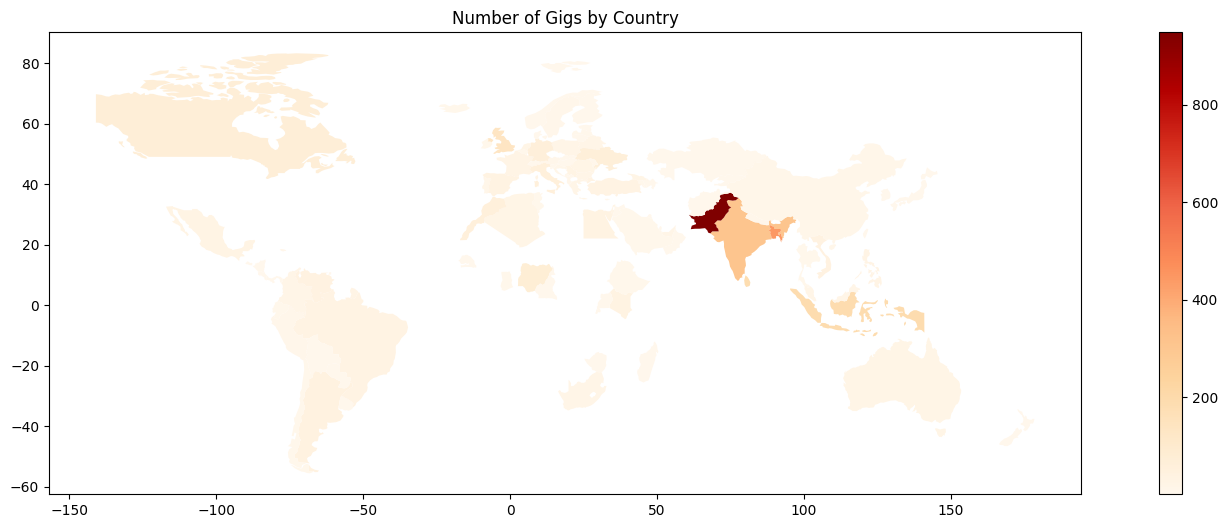

In [131]:
import geopandas as gpd

# visualize the distribution of the gigs in the world map (use the 'country' column in the gigs_data_cleaned dataframe)
country_count = gigs_data_cleaned['country'].value_counts().reset_index()
country_count.columns = ['name', 'count']

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# merge the world map with the country_count dataframe on the 'name' column
merged = world.merge(country_count, on='name')

# plot the merged dataframe using geopandas
fig, ax = plt.subplots(figsize=(20, 6))
merged.plot(column='count', cmap='OrRd', legend=True, ax=ax)
ax.set_title('Number of Gigs by Country')
plt.show()

# now visualize the same, but only for the gigs with score above the median
country_count = gigs_data_cleaned[gigs_data_cleaned['score'] > median_score]['country'].value_counts().reset_index()
country_count.columns = ['name', 'count']

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# merge the world map with the country_count dataframe on the 'name' column
merged = world.merge(country_count, on='name')

# plot the merged dataframe using geopandas
fig, ax = plt.subplots(figsize=(20, 6))
merged.plot(column='count', cmap='OrRd', legend=True, ax=ax)
ax.set_title('Number of Gigs by Country')
plt.show()

# Let's try to predict if a specific gig will do good (in score)

importing all the libreries

In [1]:
import numpy as np
from sklearn import metrics
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import pandas as pd
import pickle

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

we have to also open the gigs data frame

In [2]:
# import the gigs_data_cleaned.df (pickle) file
with open('gigs_data_cleaned.df', 'rb') as f:
    gigs_data_cleaned = pickle.load(f)
gigs_data_cleaned.head()

,gig_title,rating_score,orders_in_queue,rating_counts,seller_level,category,delivery_times,prices,revisions,tags,language,country,member_since,features
0,I will design product advertisement poster and...,4.9,4,411,2,Poster Design,"[4, 4, 5]","[117.33, 156.44, 332.43]","[3, 6, inf]","['advertising poste', 'product poste', 'facebo...","English, Hindi",India,2019-06-01,"['1 Poster design + JPG, PNG, Print-Ready PDF ..."
1,I will make an animated lottie json for web or...,5.0,0,576,3,Lottie & Web Animation,"[2, 2, 3]","[136.88, 273.77, 625.76]","[1, 2, 2]","['lotti', 'gi', 'websit', 'sv']","English, Ukrainian",Ukraine,2020-03-01,"['Basic animation of one element - icon, butto..."
2,I will create high converting google ads ppc a...,4.9,3,27,2,Search Engine Marketing Management,"[4, 7, 10]","[567.09, 1017.0, 1350.0]","[1, 1, 1]","['google adword', 'google ad']","English, Czech, German",Germany,2021-04-01,['Setup 1 Campaign + Keywords Research + High...
3,I will do editing and fact checking ai generat...,5.0,0,1,1,Fact Checking,"[1, 1, 1]","[19.55, 39.11, 58.66]","[0, 0, 0]","['a', 'copywritin', 'article write']","English, Urdu",Pakistan,2021-11-01,"['i will write using chatgpt ', 'i will write ..."
4,I will create a pixel collectibles for nft col...,5.0,2,241,2,NFT Art,"[2, 3, 5]","[39.11, 136.88, 254.21]","[1, 1, 1]","['nft ar', 'nft desig', 'nft pixel ar', 'nf']","English, Indonesian, Javanese",Indonesia,2019-09-01,['[CONTACT ME FIRST BEFORE ORDER]\r\nYou can g...


Let's make a function to visualize the tree.

In [3]:
def print_tree(clf, feature_names):
    iris = datasets.load_iris()
    X = iris.data
    y = iris.target
    fig = plt.figure(figsize=(25,20))
    _ = tree.plot_tree(clf, 
                   feature_names=feature_names,  
                   class_names=iris.target_names,
                   filled=True)

After importing the libreries, and vizualising the future trees, we can start with the machine learning.
Let's start with just the 'seller_level' for now.

Prediction precision precentage:  12.079896177493076


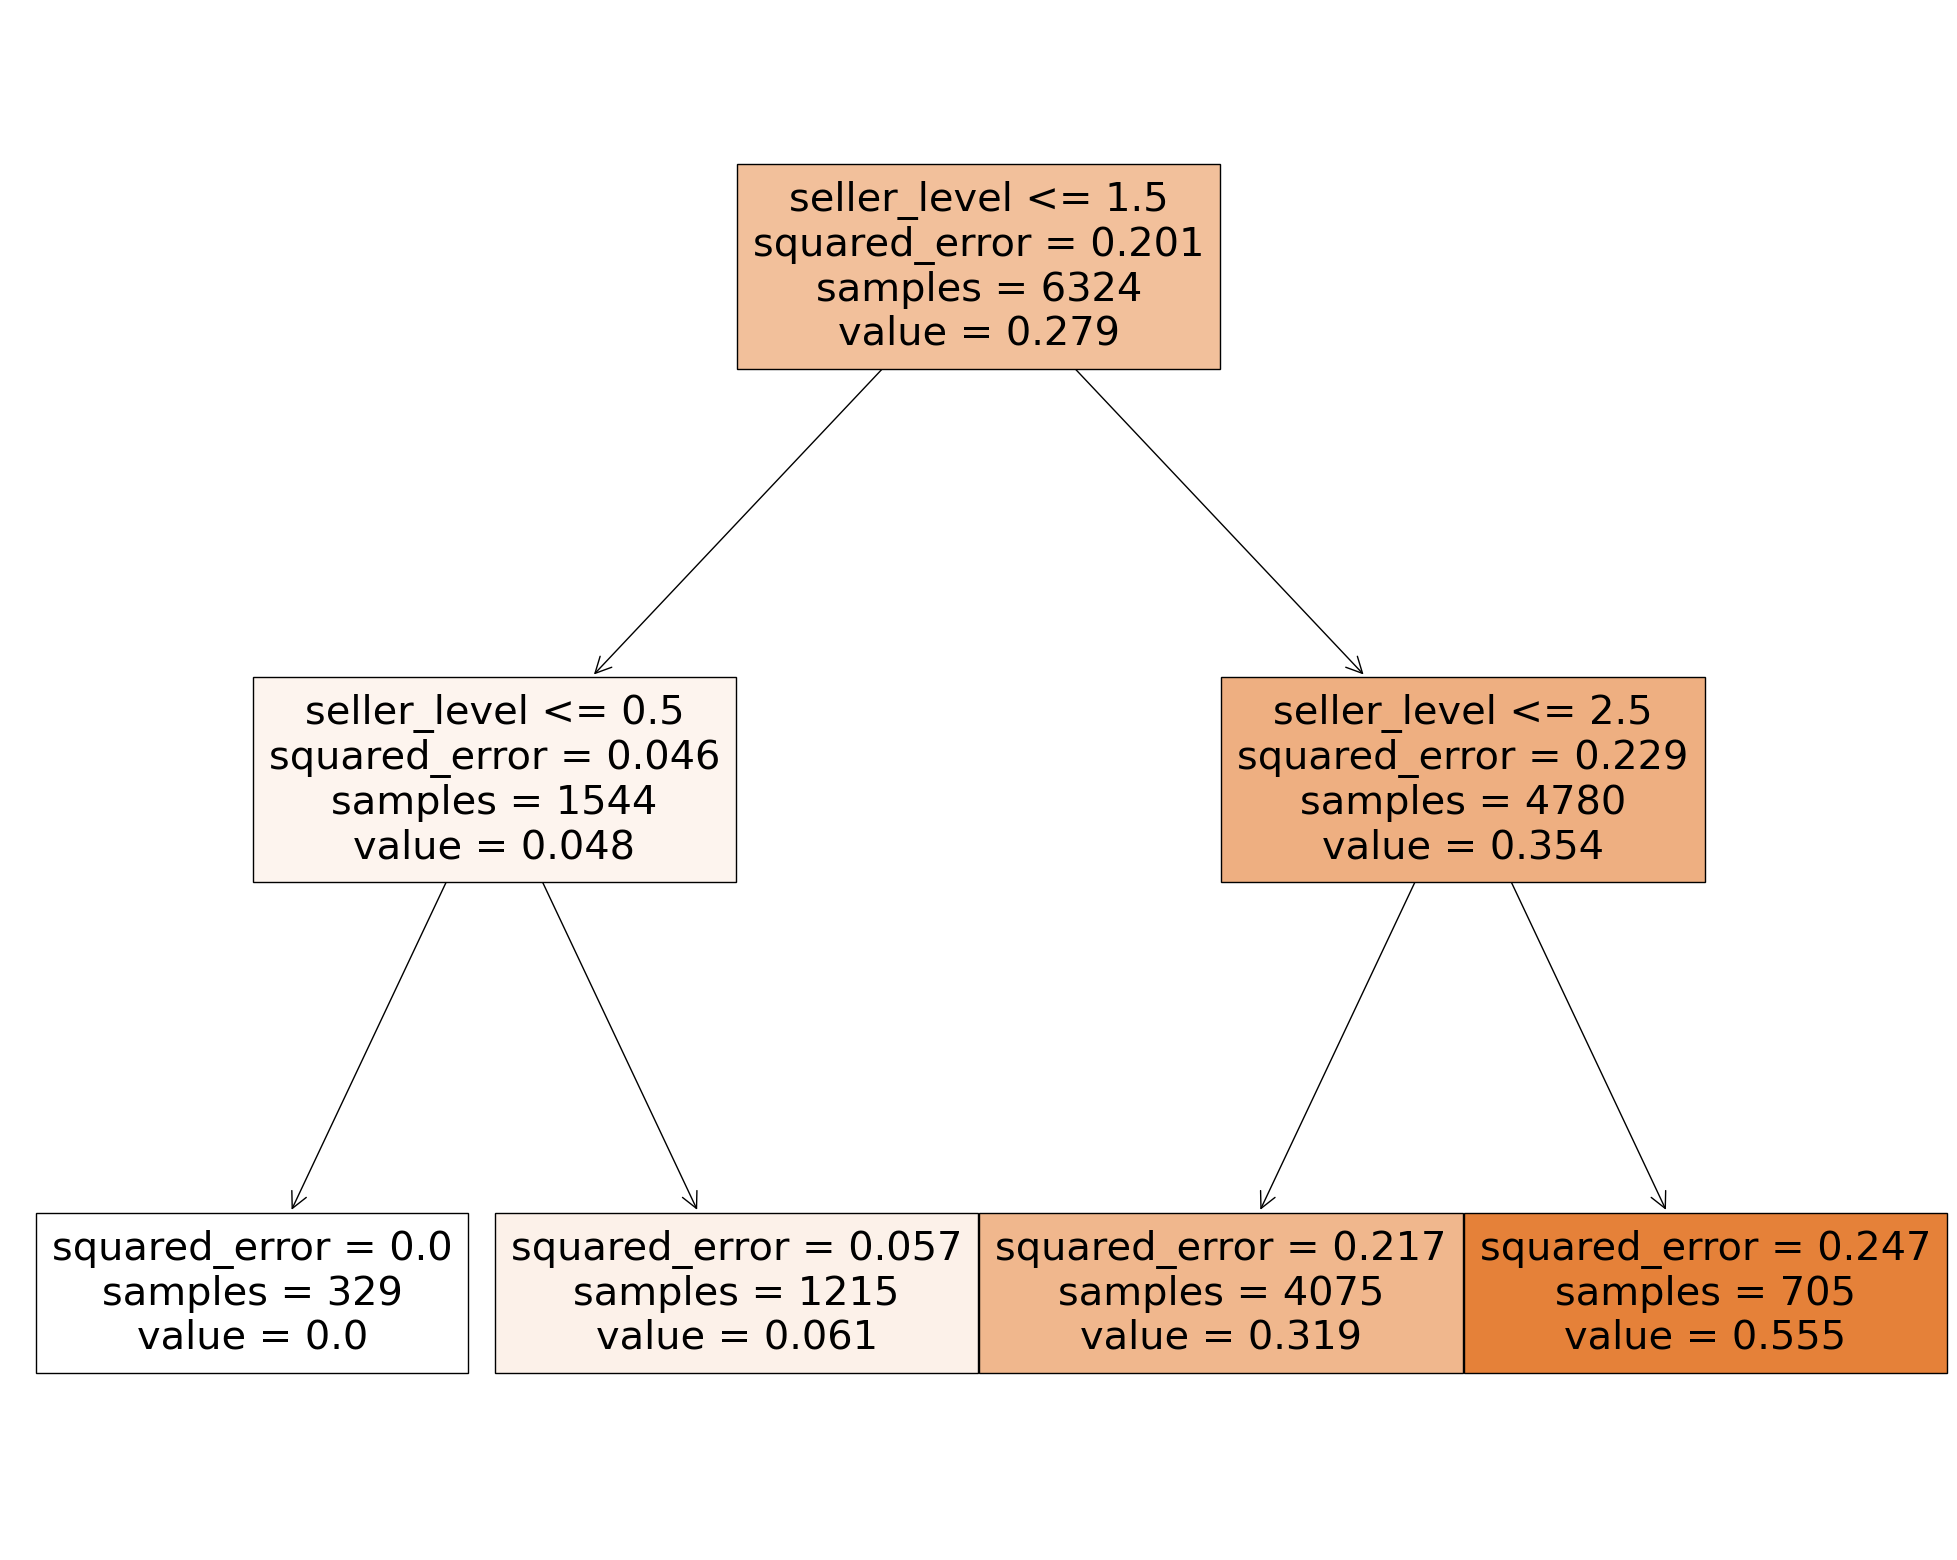

In [4]:
# Add the score column
gigs_data_cleaned['rating_counts'] = pd.to_numeric(gigs_data_cleaned['rating_counts'], errors='coerce')
gigs_data_cleaned['rating_score'] = pd.to_numeric(gigs_data_cleaned['rating_score'], errors='coerce')
gigs_data_cleaned['score'] = gigs_data_cleaned['rating_counts'] * gigs_data_cleaned['rating_score']
gigs_data_cleaned = gigs_data_cleaned.dropna(subset=['score'])
avg = gigs_data_cleaned['score'].mean()

X_train, X_test, y_train, y_test = train_test_split(gigs_data_cleaned[['seller_level']], gigs_data_cleaned['score'] >= avg, test_size=0.2, random_state=42)
descision_tree = tree.DecisionTreeRegressor(random_state=42)
model = descision_tree.fit(X_train, y_train)
y_pred = model.predict(X_test)

# calculate prediction precision precentage in precentage
print('Prediction precision precentage: ', model.score(X_test, y_test)*100)

print_tree(model, ["seller_level"])

We got a very low precision precentage, we will have to add more data in the future, or maybe change the data to increese it.
For now let's add the other numeric value - 'orders_in_queue'.

Prediction precision precentage:  23.147875348349125


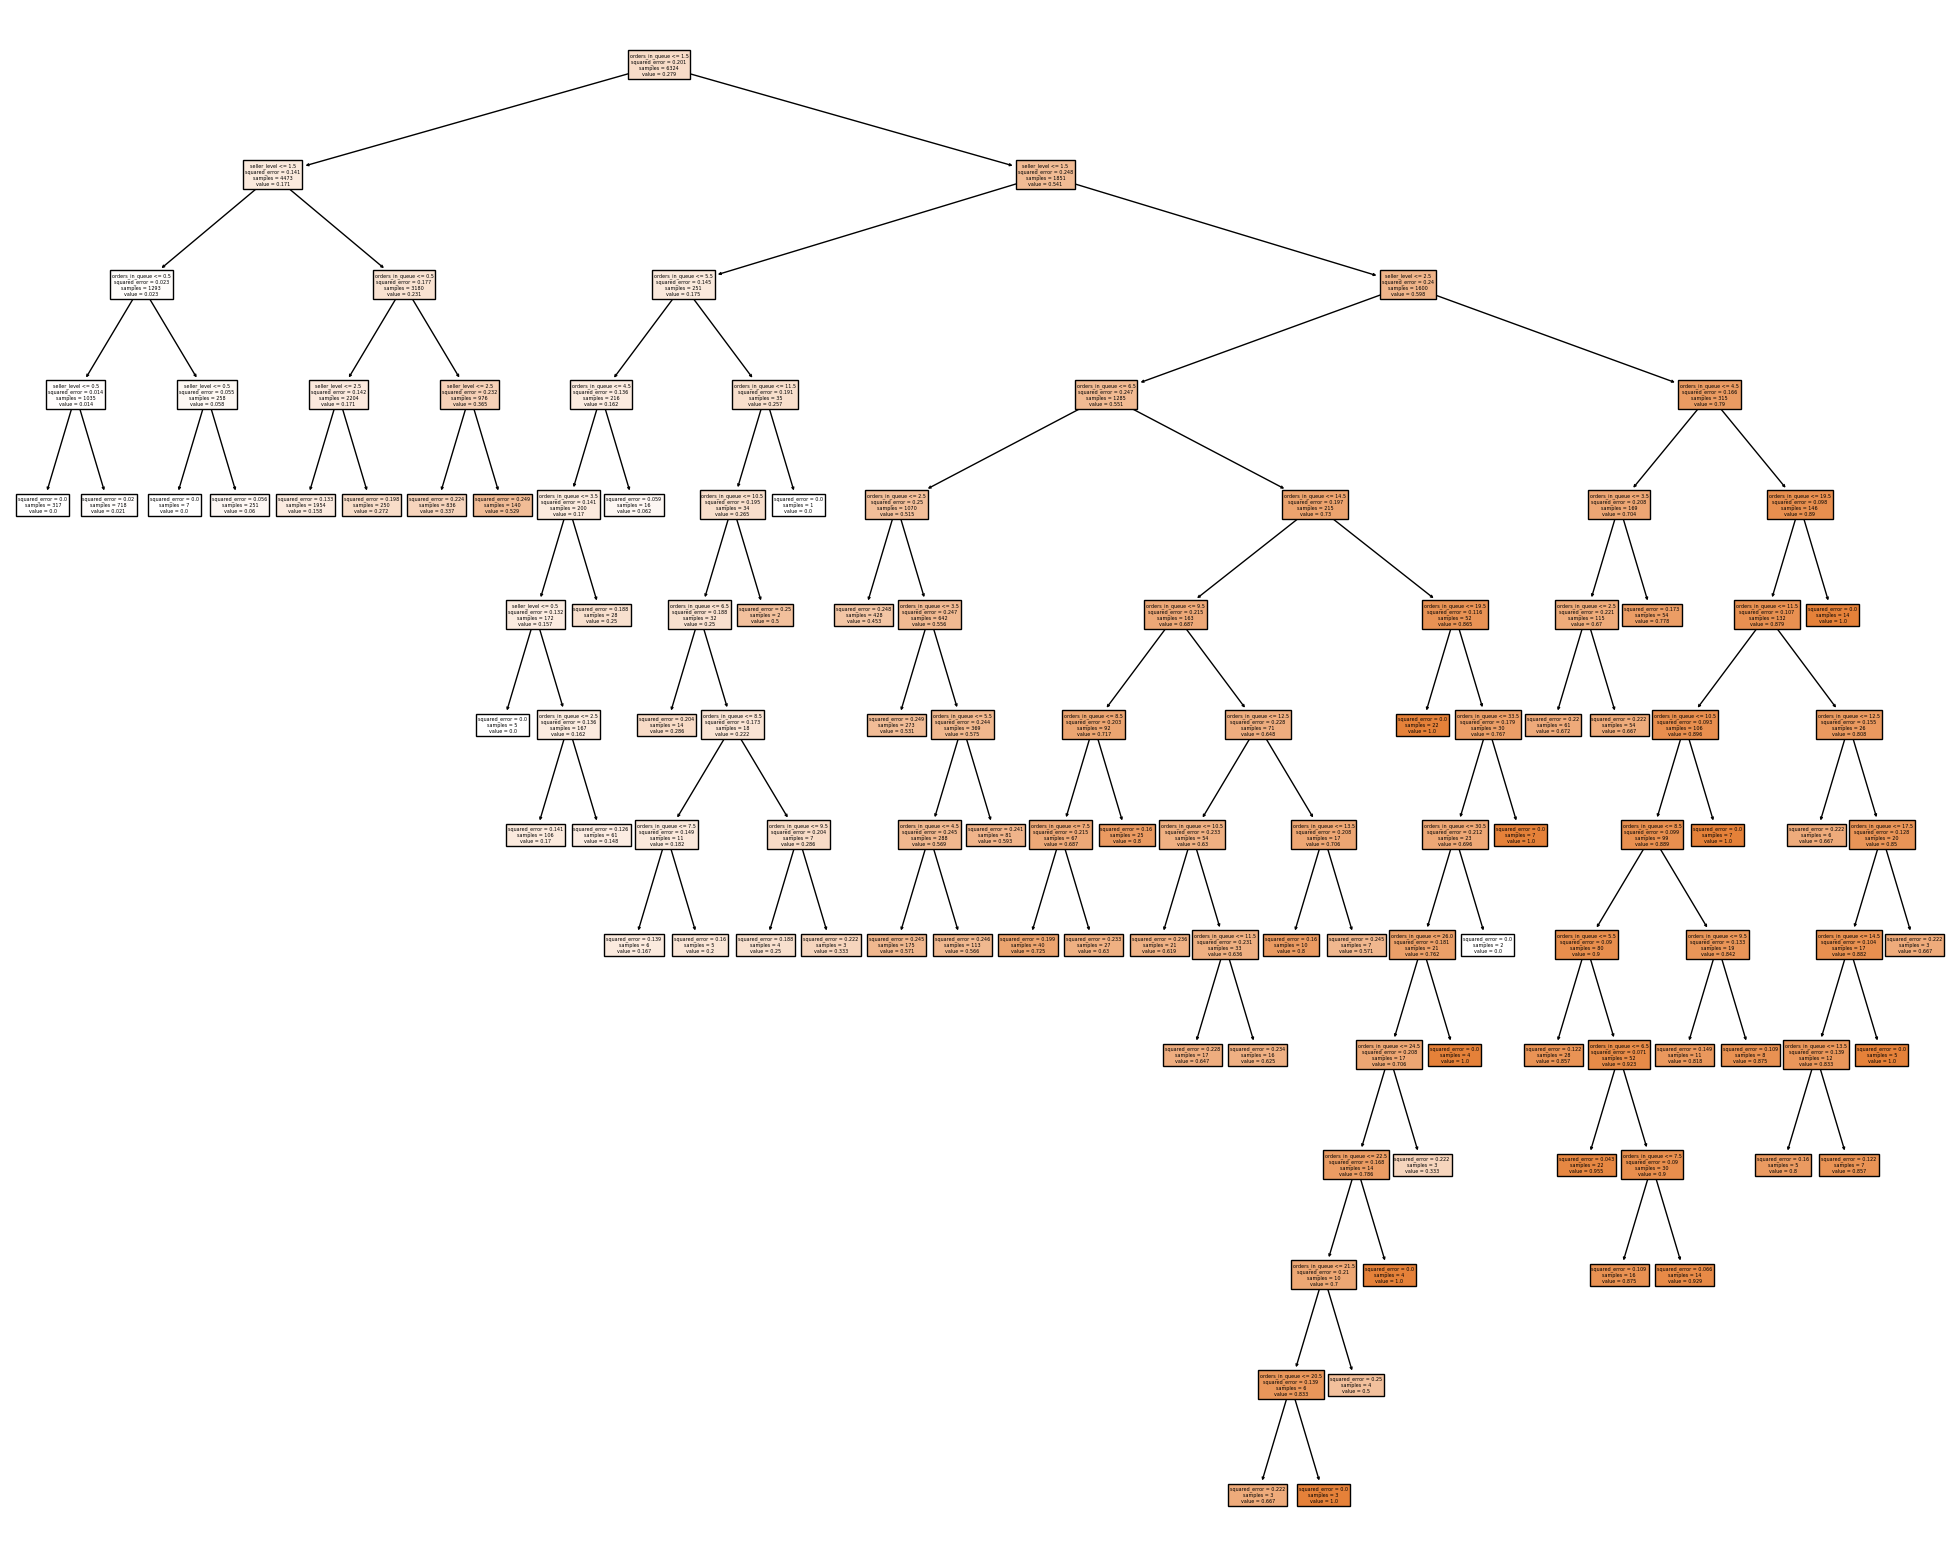

In [5]:
feature_names = ['seller_level', 'orders_in_queue']
X_train, X_test, y_train, y_test = train_test_split(gigs_data_cleaned[feature_names], gigs_data_cleaned['score'] >= avg, test_size=0.2, random_state=42)
descision_tree = tree.DecisionTreeRegressor(random_state=42)
model = descision_tree.fit(X_train, y_train)
y_pred = model.predict(X_test)

# calculate prediction precision precentage in precentage
print('Prediction precision precentage: ', model.score(X_test, y_test)*100)

print_tree(model, feature_names)

We already go a better recision precentage, just by adding 1 more feature.
Now we wil convert some data to numeric values. In addition to that we will add the 'max_depth' parameter to prevent the tree from developing too much brenches (its is making it worse over time).

['seller_level', 'orders_in_queue', 'prices', 'delivery_times', 'revisions']
Prediction precision precentage:  25.1699150733404


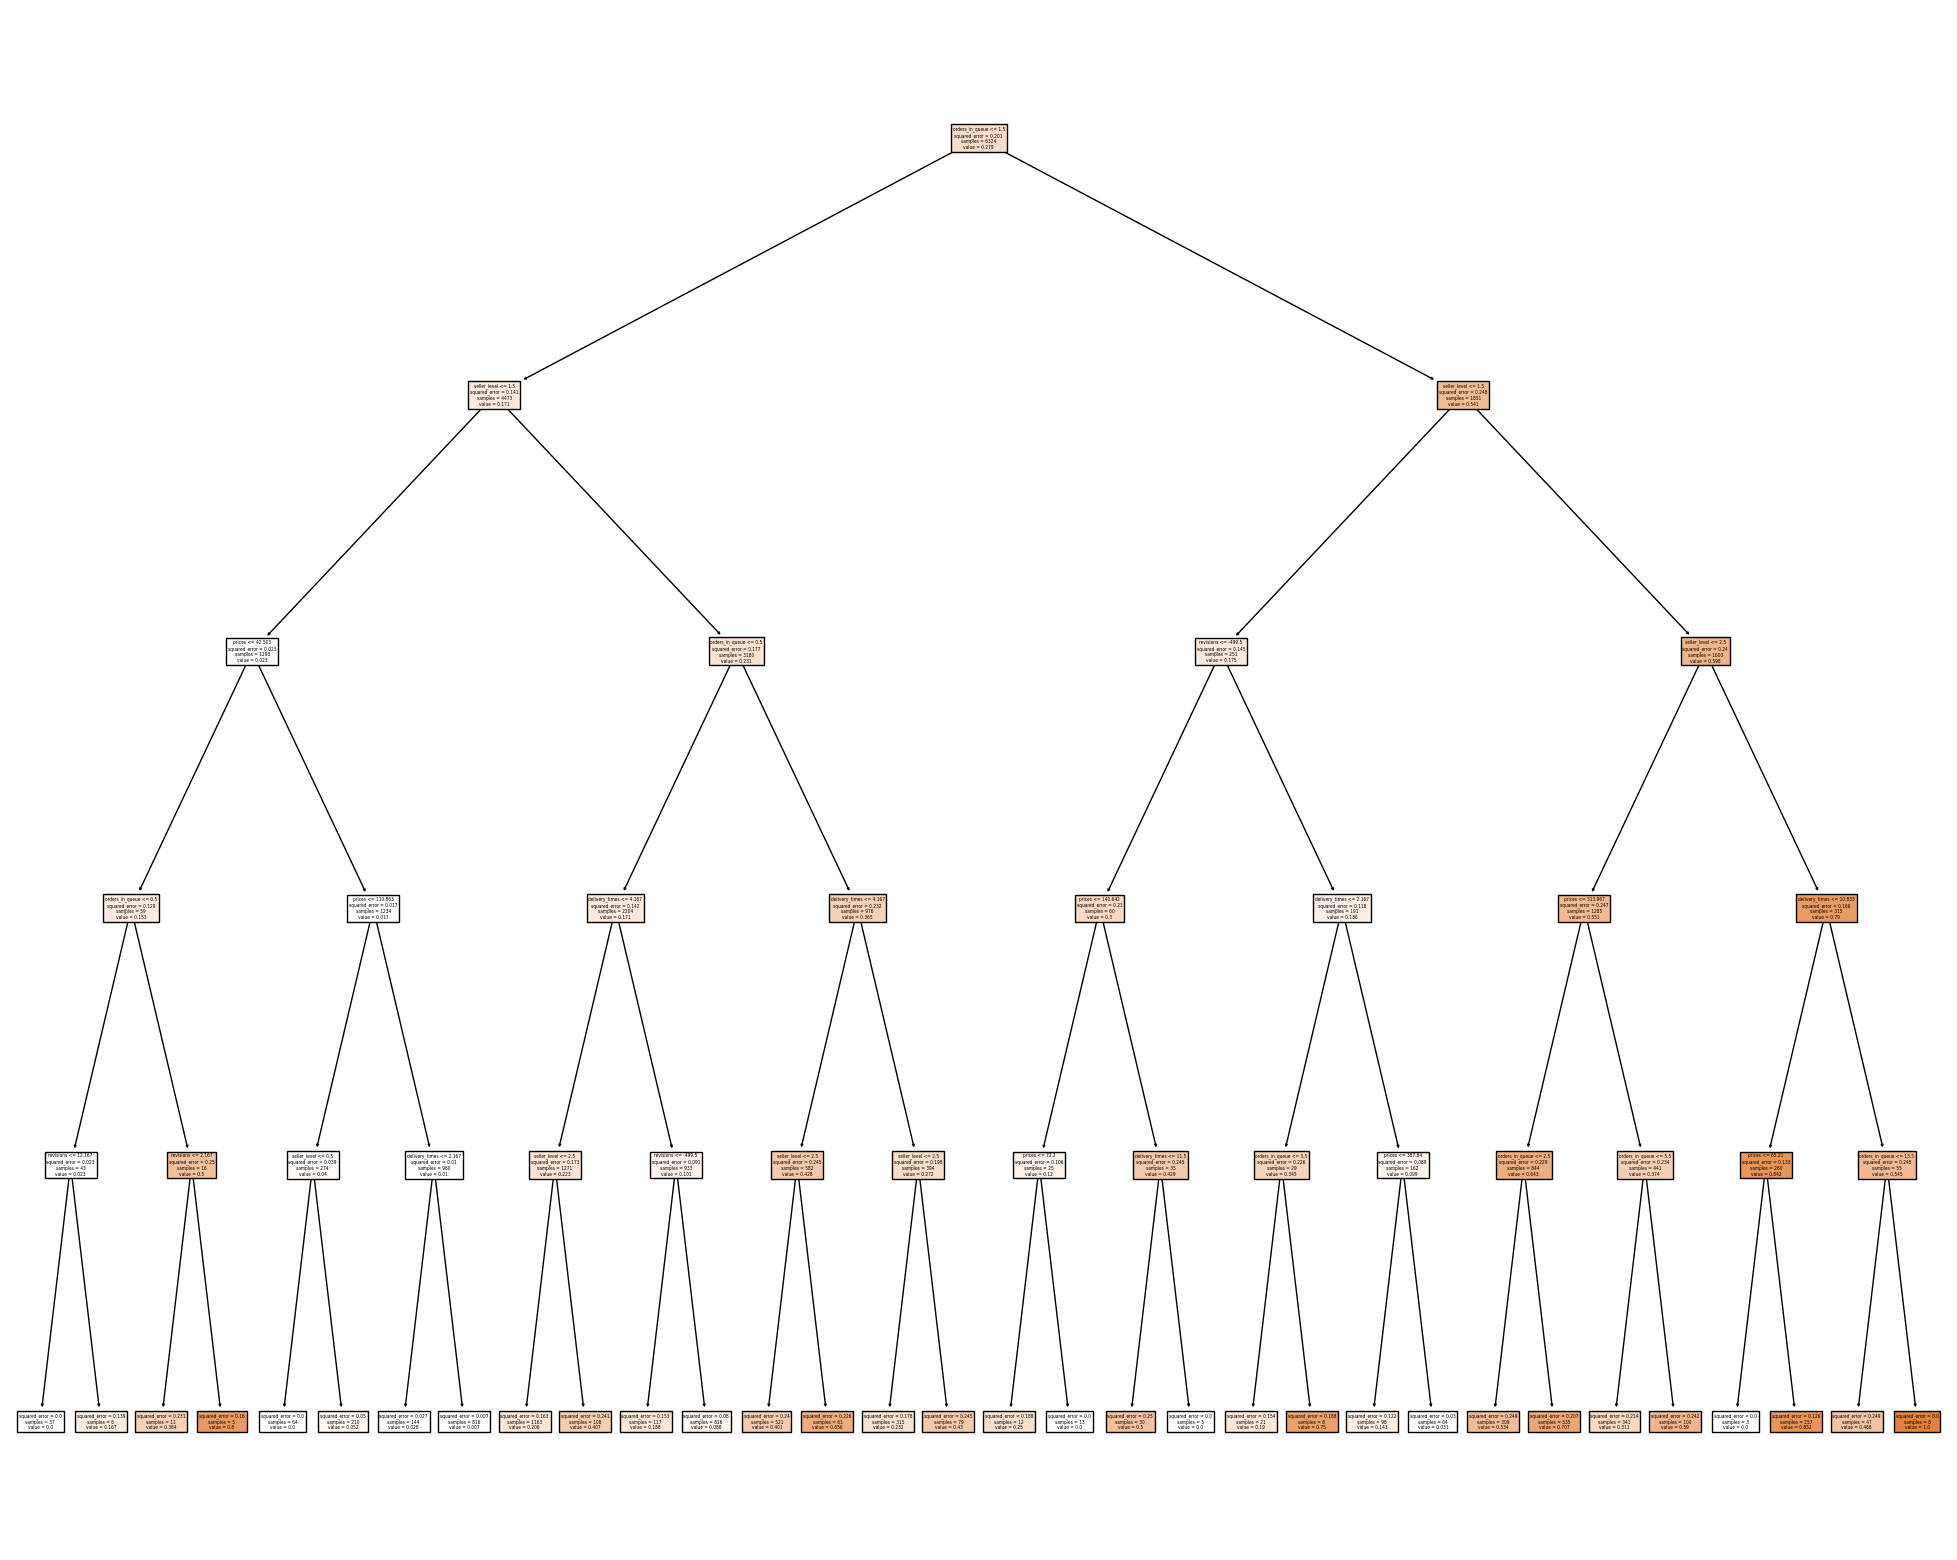

In [8]:
gigs_data_cleaned['prices'] = gigs_data_cleaned['prices'].apply(lambda x: np.mean(x))
gigs_data_cleaned['delivery_times'] = gigs_data_cleaned['delivery_times'].apply(lambda x: np.mean(x))
# if revisions is inf, replace it with -1
gigs_data_cleaned['revisions'] = gigs_data_cleaned['revisions'].replace([np.inf, -np.inf], -999)
gigs_data_cleaned['revisions'] = gigs_data_cleaned['revisions'].apply(lambda x: np.mean(x))

feature_names = ['seller_level', 'orders_in_queue', 'prices', 'delivery_times', 'revisions']

print(feature_names)

X_train, X_test, y_train, y_test = train_test_split(gigs_data_cleaned[feature_names], gigs_data_cleaned['score'] >= avg, test_size=0.2, random_state=42)
descision_tree = tree.DecisionTreeRegressor(random_state=42, max_depth = 5)
model = descision_tree.fit(X_train, y_train)
y_pred = model.predict(X_test)

# calculate prediction precision precentage in precentage
print('Prediction precision precentage: ', model.score(X_test, y_test)*100)

print_tree(model, feature_names)

Let's add more categories to try and get a better score.

Prediction precision precentage:  25.46342922250662


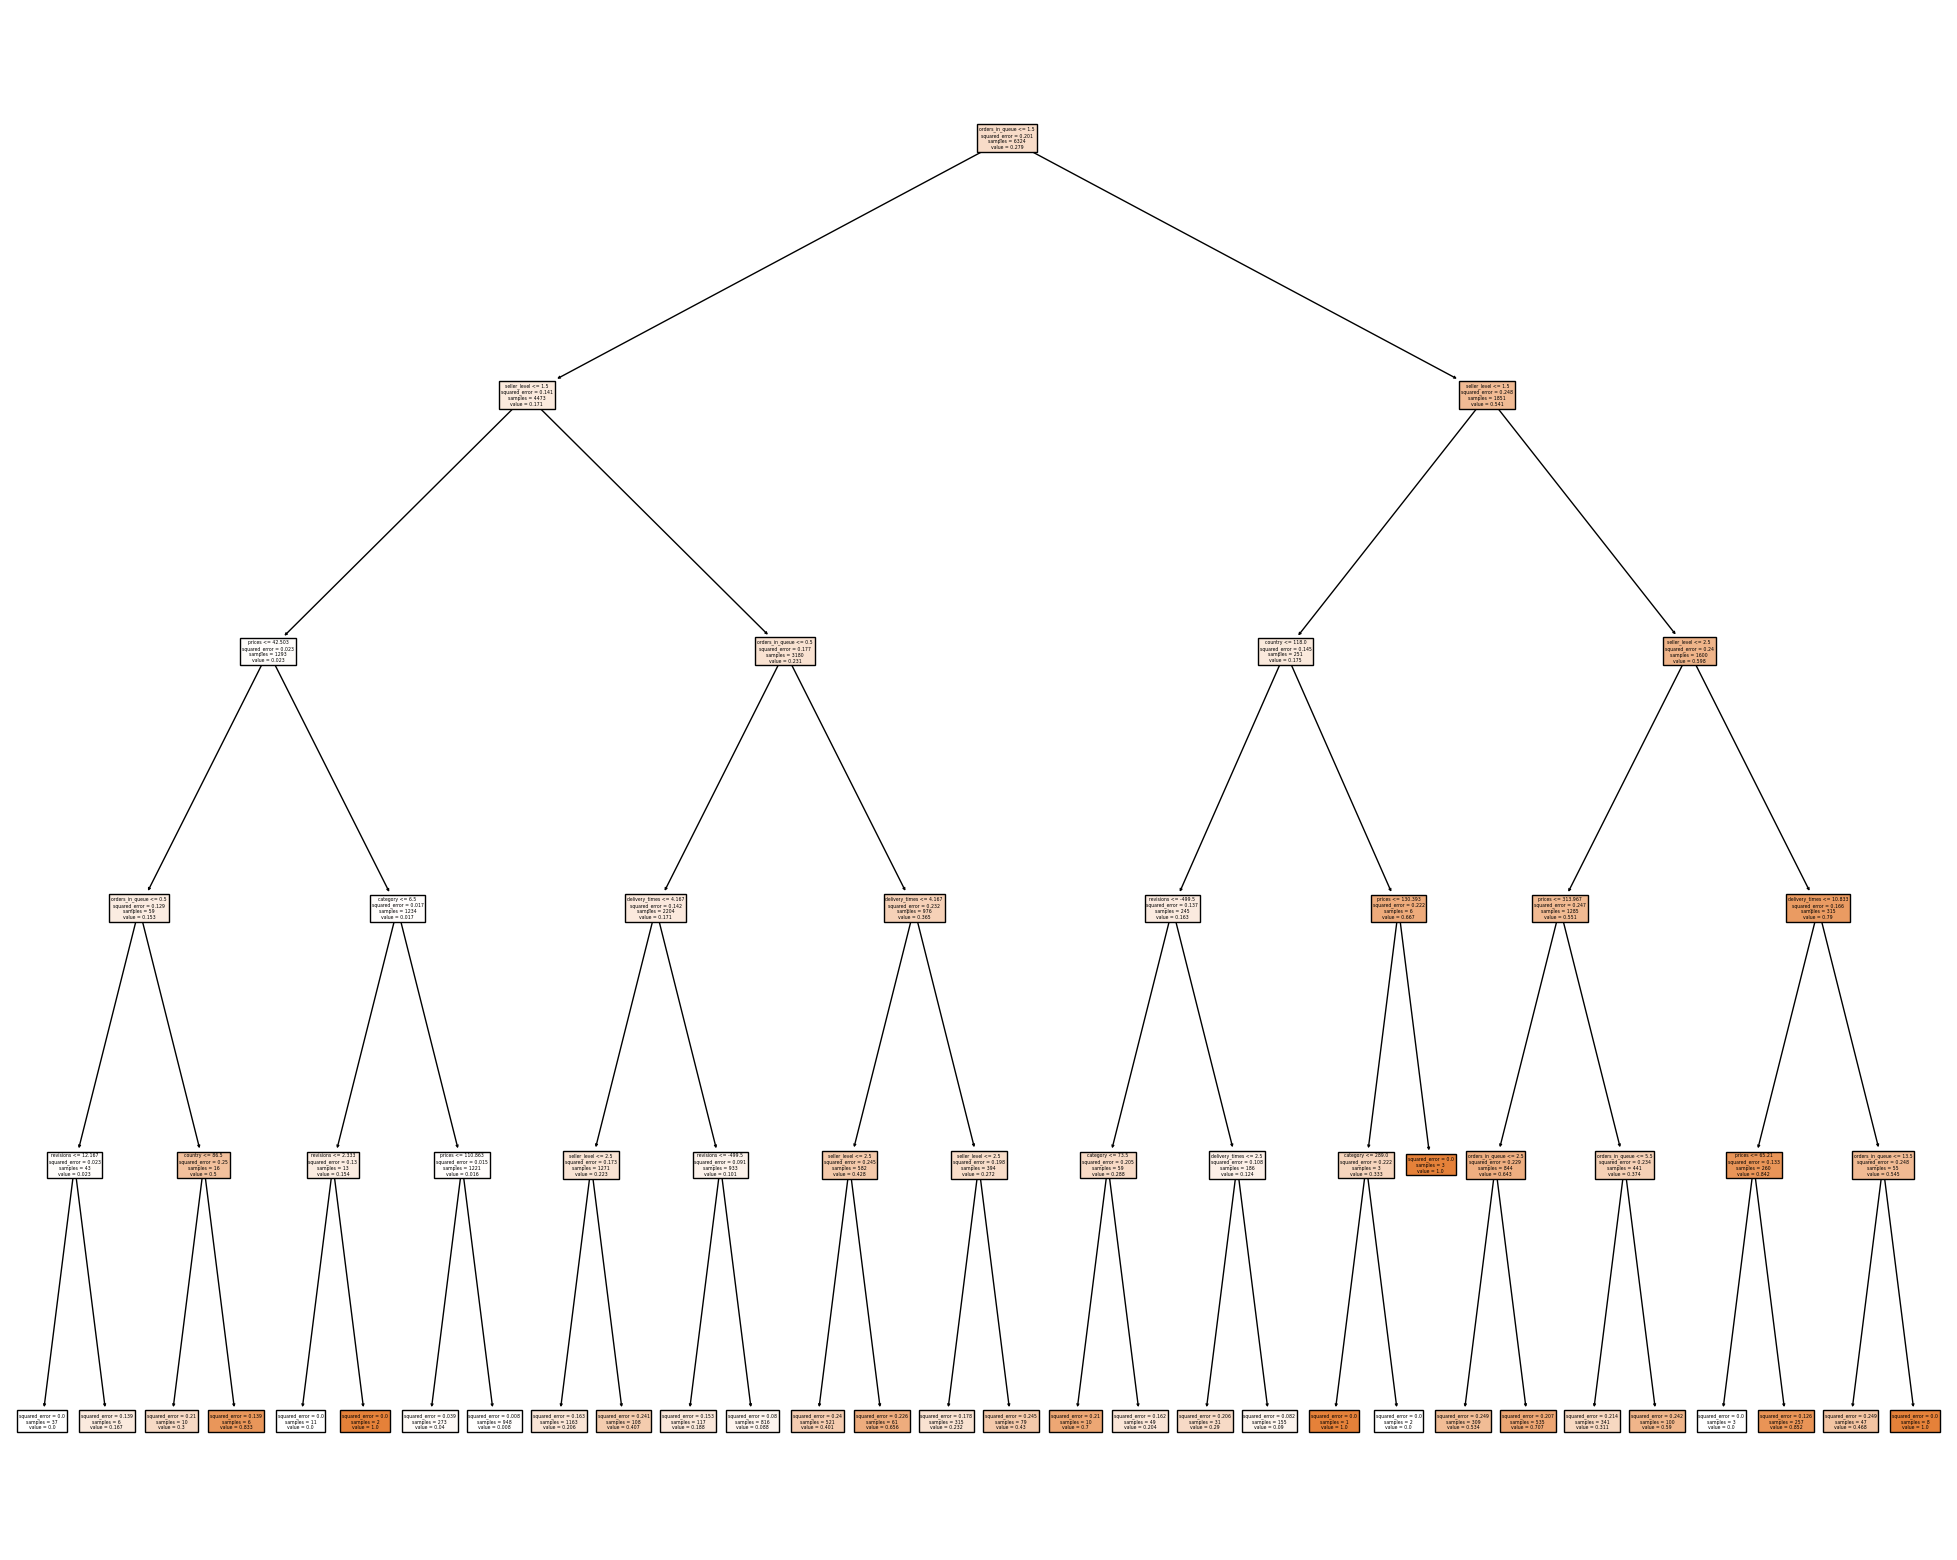

In [10]:
gigs_data_cleaned['category'] = pd.Categorical(gigs_data_cleaned['category'])
gigs_data_cleaned['country'] = pd.Categorical(gigs_data_cleaned['country'])
gigs_data_cleaned['category'] = gigs_data_cleaned['category'].cat.codes
gigs_data_cleaned['country'] = gigs_data_cleaned['country'].cat.codes


feature_names = ['seller_level', 'orders_in_queue', 'prices', 'delivery_times', 'revisions', 'category', 'country']
X_train, X_test, y_train, y_test = train_test_split(gigs_data_cleaned[feature_names], gigs_data_cleaned['score'] >= avg, test_size=0.2, random_state=42)

model = tree.DecisionTreeRegressor(random_state=42, max_depth=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# calculate prediction precision precentage in precentage
print('Prediction precision precentage: ', model.score(X_test, y_test)*100)

print_tree(model, feature_names)

In [11]:
# convert member_since from datetime to numeric
gigs_data_cleaned['member_since'] = pd.to_numeric(gigs_data_cleaned['member_since'], errors='coerce')
gigs_data_cleaned['member_since'] = gigs_data_cleaned['member_since'].fillna(0)
gigs_data_cleaned['member_since'] = gigs_data_cleaned['member_since'].astype(int)
gigs_data_cleaned['member_since'] = gigs_data_cleaned['member_since'].apply(lambda x: 2020 - x)
gigs_data_cleaned['month'] = gigs_data_cleaned['member_since'].apply(lambda x: x % 12)
gigs_data_cleaned['year'] = gigs_data_cleaned['member_since'].apply(lambda x: x // 12)
gigs_data_cleaned['gig_title'] = pd.Categorical(gigs_data_cleaned['gig_title'])
gigs_data_cleaned['gig_title'] = gigs_data_cleaned['gig_title'].cat.codes
gigs_data_cleaned['tags'] = gigs_data_cleaned['tags'].apply(lambda x: len(x))

feature_names = ['seller_level', 'orders_in_queue', 'prices', 'delivery_times', 'revisions', 'category', 'country',
                'month', 'year', 'gig_title', 'tags']
X_train, X_test, y_train, y_test = train_test_split(gigs_data_cleaned[feature_names], gigs_data_cleaned['score'] >= avg, test_size=0.2, random_state=42)

model = tree.DecisionTreeRegressor(random_state=42, max_depth=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# calculate prediction precision precentage in precentage
print('Prediction precision precentage: ', model.score(X_test, y_test)*100)


Prediction precision precentage:  23.330300166124285


We added all the categories to the cleaned data frame. We will have to find another way to boost the precision. 

# Random Forest
Another way to improve our precision is to use a Random Forest. Random Forest is a popular machine learning algorithm used for both classification and regression tasks. It is an ensemble learning method that combines multiple decision trees to make predictions.

In [28]:
feature_names = ['seller_level', 'orders_in_queue', 'prices', 'delivery_times', 'revisions', 'category', 'country',
                'month', 'year', 'gig_title', 'tags']

sfm = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold=0)
sfm.fit(gigs_data_cleaned[feature_names], gigs_data_cleaned['score'] >= avg)
X_transform = sfm.transform(gigs_data_cleaned[feature_names])
n_features = X_transform.shape[1]
print(n_features)

X_train, X_test, y_train, y_test = train_test_split(X_transform, gigs_data_cleaned['score'] >= avg , test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=500, random_state=42, max_depth=None, min_samples_leaf=1, min_samples_split=7)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


# calculate prediction precision precentage in precentage
print('Prediction precision precentage: ', model.score(X_test, y_test)*100)

11
Prediction precision precentage:  84.75648323845667


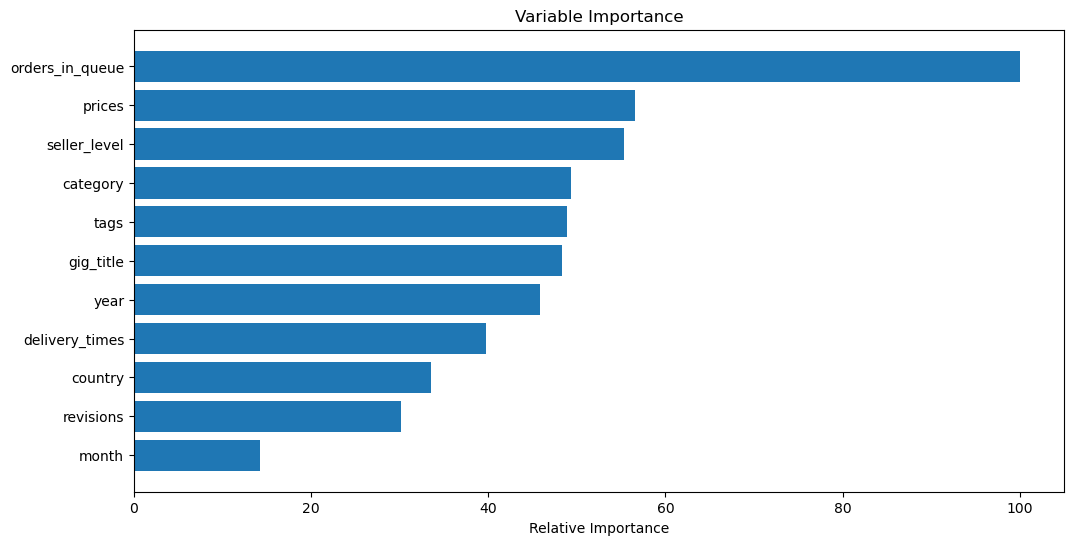

In [14]:
# plot the feature importance
feature_importance = model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')

plt.yticks(pos, gigs_data_cleaned[feature_names].columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

We got to a precision of 84.75%, wich is much better than the 12% and 23% that we had at the begining. We also found out that the 'orders_in_queue' parameter has a high value.